In [7]:
%pylab inline

import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [9]:
import os
import sys
sys.path.append(os.environ.get('PYTHONPATH', None))

In [10]:
import util

In [11]:
pd.set_option('display.width', 120)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

## Logistic Regression

* Usually events are used to collect user actions.
* In Redshift each event is stored in a single row.

* As input to Logistic Regression one row per user is required.
* The row contains all features calculated for each member.

### Transform Data

In [12]:
def pivot(action):
    df = pd.DataFrame(action, columns=['summary_day', 'member_id', 'event', 'score'])
    pk_columns = ['summary_day', 'member_id']

    # PIVOT
    df_pk = df[pk_columns]

    df_col = df[['event', 'score']]
    df_col.index.name = 'uniq'
    df_col.reset_index(inplace=True)

    df = df_col.pivot('uniq', 'event', 'score')
    df.fillna(0, inplace=True)

    df = pd.concat([df, df_pk], axis=1, join='inner')

    # GROUP BY
    groups = df.groupby(pk_columns)
    groups_sum = groups.aggregate(np.sum)
    groups_sum.reset_index(inplace=True)
    
    return groups_sum


def create_train(df, churn):
    df_c = pd.DataFrame(churn, columns=['member_id', 'pro_churn'])
    df = pd.merge(df, df_c, how='inner', on='member_id')
    return df


def train(df):
    y = np.array(df['pro_churn'])
    print y

    X = np.array(df.drop(['summary_day', 'member_id', 'pro_churn'], axis=1, inplace=False))
    print X

    rgr = LogisticRegression()
    rgr.fit(X, y)
    print ">> coefficients <<"
    print rgr.coef_

#   print np.dot(X, np.transpose(rgr.coef_))

    # store the trained model
    import pickle
    stored_model = pickle.dumps(rgr)

    return stored_model


def predict(df, ml_model, X):
    import pickle
    clf = pickle.loads(ml_model)
    
    print ">> predicted <<"
    y = clf.predict(X)
    print y

    df_y = pd.DataFrame(y, columns=['y'])
    df = pd.concat([df, df_y], axis=1, join='inner')

    return df

## Example: 2 features
```
features: ['send_message', 'add_sn']
```

In [14]:
action = [
     ('2015-05-19', 1, 'send_message', 1),
     ('2015-05-19', 1, 'add_sn', 1),
     ('2015-05-19', 2, 'add_sn', 1), 
     ('2015-05-19', 3, 'add_sn', 1),
     ('2015-05-19', 2, 'send_message', 7),
     ('2015-05-19', 4, 'add_sn', 1),
     ('2015-05-19', 2, 'send_message', 1),
     ('2015-05-19', 1, 'add_sn', 1),
     ('2015-05-19', 2, 'send_message', 1), 
     ('2015-05-19', 4, 'add_sn', 1),
     ('2015-05-19', 2, 'add_sn', 1),
     ('2015-05-19', 4, 'send_message', 1),
     ('2015-05-19', 2, 'send_message', 1), 
     ('2015-05-19', 4, 'add_sn', 1),
     ('2015-05-19', 2, 'add_sn', 1),
     ('2015-05-19', 4, 'send_message', 1),
     ]

churn_7 = [
    (1, 0),
    (2, 1),
    (3, 0),
    (4, 0),
    ]

### Train

In [15]:
df = pivot(action)
df = create_train(df, churn_7)
stored_model = train(df)

[0 1 0 0]
[[  2.   1.]
 [  3.  10.]
 [  1.   0.]
 [  3.   2.]]
>> coefficients <<
[[-0.75410768  0.49477919]]


### Predict

In [16]:
new_action = [
     ('2015-05-20', 5, 'send_message', 1),
     ('2015-05-20', 5, 'add_sn', 1),
     ('2015-05-20', 5, 'send_message', 1), 
     ('2015-05-20', 5, 'add_sn', 1),
     ('2015-05-20', 6, 'send_message', 1),
     ('2015-05-20', 6, 'send_message', 1),
     ('2015-05-20', 6, 'send_message', 1), 
     ('2015-05-20', 6, 'add_sn', 1),
    ]

df = pivot(new_action)

pk_columns = ['summary_day', 'member_id']

X = np.array(df.drop(pk_columns, axis=1, inplace=False))

print ">> X <<"
print X

>> X <<
[[ 2.  2.]
 [ 1.  3.]]


In [17]:
df = predict(df, stored_model, X)

print ">> result <<"
print df

>> predicted <<
[0 1]
>> result <<
event summary_day  member_id  add_sn  send_message  y
0      2015-05-20          5       2             2  0
1      2015-05-20          6       1             3  1


## Estimator Performance

1. train and predict
2. compare predicted with known correct scores using ROC, Confusion Matrix

### ROC

In [19]:
df = pivot(action + new_action)

In [20]:
y = np.array(churn_7 + [(5,0), (6,1)])
X = np.array(df.drop(['summary_day', 'member_id'], axis=1, inplace=False))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y[:,1:],
                                                    test_size=0.2,
                                                    random_state=0)

In [22]:
rgr = LogisticRegression()
rgr.fit(X_train, y_train.ravel())
y_score = rgr.predict(X_test)

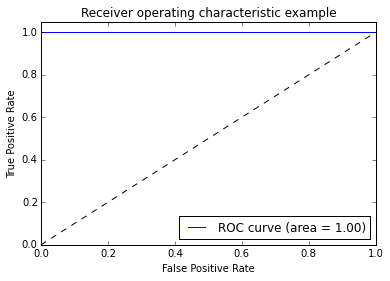

In [23]:
util.plot_roc(y_test, y_score)

### Confusion Matrix

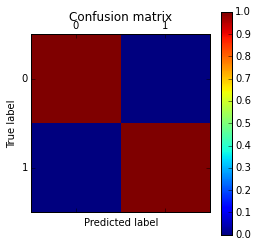

In [27]:
util.plot_confusion_matrix(y_test, y_score)

## Example: 6 features

In [24]:
action = [
     ('2015-05-19', 1, 'use_app', 1),
     ('2015-05-19', 1, 'add_sn', 1),
     ('2015-05-19', 2, 'add_sn', 1), 
     ('2015-05-19', 3, 'add_team', 1),
     ('2015-05-19', 2, 'account_age', 7),
     ('2015-05-19', 4, 'drop_sn', -1),
     ('2015-05-19', 2, 'use_app', 1),
     ('2015-05-19', 1, 'add_sn', 1),
     ('2015-05-19', 2, 'send_message', 1), 
     ('2015-05-19', 4, 'add_team', 1),
     ('2015-05-19', 2, 'add_sn', 1),
     ('2015-05-19', 4, 'account_age', -1),
     ('2015-05-19', 2, 'send_message', 1), 
     ('2015-05-19', 4, 'add_team', 1),
     ('2015-05-19', 2, 'add_sn', 1),
     ('2015-05-19', 4, 'send_message', 1),
     ]

churn_7 = [
    (1, 0),
    (2, 1),
    (3, 0),
    (4, 0),
    ]

### Train

In [25]:
df = pivot(action)
df = create_train(df, churn_7)
stored_model = train(df)

[0 1 0 0]
[[ 0.  2.  0.  0.  0.  1.]
 [ 7.  3.  0.  0.  2.  1.]
 [ 0.  0.  1.  0.  0.  0.]
 [-1.  0.  2. -1.  1.  0.]]
>> coefficients <<
[[ 0.57668285 -0.25711866 -0.47711878  0.1051984   0.02951144 -0.16223679]]


### Predict

In [26]:
new_action = [
     ('2015-05-20', 5, 'send_message', 1),
     ('2015-05-20', 5, 'add_sn', 1),
     ('2015-05-20', 5, 'send_message', 1), 
     ('2015-05-20', 5, 'add_team', 0),
     ('2015-05-20', 5, 'account_age', 2),
     ('2015-05-20', 5, 'drop_sn', 0),
     ('2015-05-20', 5, 'use_app', 0),
     ('2015-05-20', 6, 'send_message', 1),
     ('2015-05-20', 6, 'send_message', 1),
     ('2015-05-20', 6, 'send_message', 1), 
     ('2015-05-20', 6, 'add_sn', 1),
     ('2015-05-20', 6, 'add_team', 0),
     ('2015-05-20', 6, 'account_age', 4),
     ('2015-05-20', 6, 'drop_sn', 0),
     ('2015-05-20', 6, 'use_app', 0),
    ]

df = pivot(new_action)

pk_columns = ['summary_day', 'member_id']

X = np.array(df.drop(pk_columns, axis=1, inplace=False))
print X

df = predict(df, stored_model, X)

print ">> result <<"
print df

[[ 2.  1.  0.  0.  2.  0.]
 [ 4.  1.  0.  0.  3.  0.]]
>> predicted <<
[1 1]
>> result <<
event summary_day  member_id  account_age  add_sn  add_team  drop_sn  send_message  use_app  y
0      2015-05-20          5            2       1         0        0             2        0  1
1      2015-05-20          6            4       1         0        0             3        0  1
